<a href="https://colab.research.google.com/github/Quillbolt/colabnotebook/blob/main/crnn_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install trdg

     |████████████████████████████████| 91.2MB 53kB/s 
     |████████████████████████████████| 50.4MB 66kB/s 
     |████████████████████████████████| 17.4MB 214kB/s 
  Created wheel for diffimg: filename=diffimg-0.2.3-cp36-none-any.whl size=4051 sha256=ea3da8aa36784ac2789ae8d6865896a3e21e96156fc3336eaeb229ebcfaa6a98
  Stored in directory: /root/.cache/pip/wheels/92/46/95/1de38a4ccb7811e6cc67fcc3594ea25180f85b70c406bdf0c3
Successfully built diffimg
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.6 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement numpy~=1.19.2, but you'll have numpy 1.16.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled nu

In [ ]:
!trdg --output_dir /content/train -c 10000 -l en -rs -num -let -w 2 --case upper  -ft /content/fonts/licenseplate.ttf -t 3 -k 15 -rk -bl 1 -rbl

2021-01-14 10:29:33.354378: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
100% 10000/10000 [00:50<00:00, 196.55it/s]


In [ ]:
!trdg --output_dir /content/train -c 10000 -l en -rs -num -let -w 2 --case upper  -ft /content/fonts/MANDATOR.ttf -t 3 -k 15 -rk -bl 1 -rbl

2021-01-14 10:30:29.146634: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
100% 10000/10000 [00:49<00:00, 202.85it/s]


In [ ]:
!trdg --output_dir /content/train -c 10000 -l en -rs -num -let -w 2 --case upper  -ft /content/fonts/Soxe2banh.ttf -t 3 -k 15 -rk -bl 1 -rbl

2021-01-14 10:31:22.788291: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
100% 10000/10000 [00:47<00:00, 208.78it/s]


In [ ]:
!trdg --output_dir /content/val -c 1000 -l en -rs -num -let -w 2 --case upper  -ft /content/fonts/Soxe2banh.ttf -t 3 -k 15 -rk -bl 1 -rbl

2021-01-14 10:32:14.971348: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
100% 1000/1000 [00:05<00:00, 192.95it/s]


In [ ]:
!trdg --output_dir /content/val -c 1000 -l en -rs -num -let -w 2 --case upper  -ft /content/fonts/MANDATOR.ttf -t 3 -k 15 -rk -bl 1 -rbl

2021-01-14 10:32:24.253947: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
100% 1000/1000 [00:05<00:00, 190.79it/s]


In [ ]:
!trdg --output_dir /content/val -c 1000 -l en -rs -num -let -w 2 --case upper  -ft /content/fonts/licenseplate.ttf -t 3 -k 15 -rk -bl 1 -rbl

2021-01-14 10:32:33.645424: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
100% 1000/1000 [00:05<00:00, 187.26it/s]


In [ ]:
!pip install textdistance

In [ ]:
import torch
import numpy as np
from collections import namedtuple
import pdb
from functools import wraps
from time import time as _timenow
from sys import stderr
import os
import pickle
import math
from PIL import Image
from operator import eq
import cv2
import random
import logging
import json
import math
from warnings import warn
import re
import string
from textdistance import levenshtein as lev

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def similarity(word1, word2):
    return lev.normalized_distance(word1, word2)

def gmkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def corrupt(x):
    if random.random() > 0.5:
        noise = np.random.binomial(1, 1.0 - 0.2, size=x.size())
        result = x.clone()
        result  *= noise
        return result
    return x

def gaussian(images):
    if random.random() > 0.5:
        mean, var = 0, 0.1
        stddev = var**2
        noise = images.data.new(images.size()).normal_(mean, stddev)
        return images + noise
    return images

def time(f):
    @wraps(f)
    def _wrapped(*args, **kwargs):
        start = _timenow()
        result = f(*args, **kwargs)
        end = _timenow()
        print('[time] {}: {}'.format(f.__name__, end - start),
              file=stderr)
        return result

    return _wrapped


def split(samples, **kwargs):
    total = len(samples)
    indices = list(range(total))
    if kwargs['random']:
        np.random.shuffle(indices)
    percent = kwargs['split']
    # Split indices
    current = 0
    train_count = np.int(percent * total)
    train_indices = indices[current:current + train_count]
    current += train_count
    test_indices = indices[current:]
    train_subset, test_subset = [], []
    for i in train_indices:
        train_subset.append(samples[i])

    for i in test_indices:
        test_subset.append(samples[i])
    return train_subset, test_subset

def text_align(prWords, gtWords):
    row, col = len(prWords), len(gtWords)
    adjMat= np.zeros((row, col), dtype=float)
    for i in range(len(prWords)):
        for j in range(len(gtWords)):
            adjMat[i, j] = similarity(prWords[i], gtWords[j])
    pr_aligned=[]
    for i in range(len(prWords)):
        nn = list(map(lambda x:gtWords[x], np.argsort(adjMat[i, :])[:1])) 
        pr_aligned.append((prWords[i], nn[0]))
    return pr_aligned

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, save_file, patience=5, verbose=False, delta=0, best_score=None):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = best_score
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.save_file = save_file
        print(best_score)

    def __call__(self, val_loss, epoch, model, optimizer):
        
        score = -val_loss
        state = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'opt_state_dict': optimizer.state_dict(),
                'best': score
                }
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, state)
        elif score < self.best_score - self.delta:

            self.counter += 1
            print(f'EarlyStopping counter: ({self.best_score:.6f} {self.counter} out of {self.patience})')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, state)
            self.counter = 0

    def save_checkpoint(self, val_loss, state):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(state, self.save_file)
        self.val_loss_min = val_loss


class AverageMeter:
    def __init__(self, name):
        self.name = name
        self.count = 0
        self.total = 0
        self.max = -1 * float("inf")
        self.min = float("inf")

    def add(self, element):
        # pdb.set_trace()
        self.total += element
        self.count += 1
        self.max = max(self.max, element)
        self.min = min(self.min, element)

    def compute(self):
        # pdb.set_trace()
        if self.count == 0:
            return float("inf")
        return self.total / self.count

    def __str__(self):
        return "%s (min, avg, max): (%.3lf, %.3lf, %.3lf)" % (self.name, self.min, self.compute(), self.max)

class Eval:
    def _blanks(self, max_vals,  max_indices):
        def get_ind(indices):
            result = []
            for i in range(len(indices)):
                if indices[i] != 0:
                    result.append(i)
            return result
        non_blank = list(map(get_ind, max_indices))
        scores = []

        for i, sub_list in enumerate(non_blank):
            sub_val = []
            if sub_list:
                for item in sub_list:
                    sub_val.append(max_vals[i][item])
            score = np.exp(np.sum(sub_val))
            if math.isnan(score):
                score = 0.0
            scores.append(score)
        return scores

class Eval:
    def _blanks(self, max_vals,  max_indices):
        def get_ind(indices):
            result = []
            for i in range(len(indices)):
                if indices[i] != 0:
                    result.append(i)
            return result
        non_blank = list(map(get_ind, max_indices))
        scores = []

        for i, sub_list in enumerate(non_blank):
            sub_val = []
            if sub_list:
                for item in sub_list:
                    sub_val.append(max_vals[i][item])
            score = np.exp(np.sum(sub_val))
            if math.isnan(score):
                score = 0.0
            scores.append(score)
        return scores


    def _clean(self, word):
        regex = re.compile('[%s]' % re.escape('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”„'))
        return regex.sub('', word)

    def char_accuracy(self, pair):
        words, truths = pair
        words, truths = ''.join(words), ''.join(truths)
        sum_edit_dists = lev.distance(words, truths)
        sum_gt_lengths = sum(map(len, truths))
        fraction = 0
        if sum_gt_lengths != 0:
            fraction = sum_edit_dists / sum_gt_lengths

        percent = fraction * 100
        if 100.0 - percent < 0:
            return 0.0
        else:
            return 100.0 - percent

    def word_accuracy(self, pair):
        correct = 0
        word, truth = pair
        if self._clean(word) == self._clean(truth):
            correct = 1
        return correct

    def format_target(self, target, target_sizes):
        target_ = []
        start = 0
        for size_ in target_sizes:
            target_.append(target[start:start + size_])
            start += size_
        return target_

    def word_accuracy_line(self, pairs):
        preds, truths = pairs
        word_pairs = text_align(preds.split(), truths.split())
        word_acc = np.mean((list(map(self.word_accuracy, word_pairs))))
        return word_acc

class OCRLabelConverter(object):
    """Convert between str and label.
    NOTE:
        Insert `blank` to the alphabet for CTC.
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=False):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1
        self.dict[''] = 0
    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        '''
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))
        '''
        length = []
        result = []
        for item in text:
            # item = item.decode('utf-8', 'strict')
            length.append(len(item))
            for char in item:
                if char in self.dict:
                    index = self.dict[char]
                else:
                    index = 0
                result.append(index)

        text = result
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(),
                                                                                                         length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(
                t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts

In [ ]:
import pdb
import torch
import numpy as np
import types
import math
from torch._six import inf
from functools import wraps
import warnings
import weakref
from bisect import bisect_right

from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
from itertools import chain

def opt_params(parm, lr):
    return {'params': chain_params(parm), 'lr':lr}

def chain_params(p):
    return list(chain(*[trainable_params_(p)]))
 

def trainable_params_(m):
    return [p for p in m.parameters() if p.requires_grad]

class LayerOptimizer(object):
	def __init__(self, layer_groups, lrs, wds):
		self.layer_groups, self.lrs, self.wds = layer_groups, lrs, wds
		self.opt = torch.optim.Adam(self.opt_params())

	def opt_params(self):
		self.layers_groups = [layer for layer in self.layer_groups if list(layer.parameters())]
		n_layers = len(self.layer_groups)
		if not isinstance(self.lrs, list):self.lrs = [self.lrs]*n_layers
		params = list(zip(self.layer_groups, self.lrs))
		return [opt_params(*p) for p in params]

class _Optimizer(object):
	def __init__(self, model, lrs, wds=None):
		self.lrs = lrs
		self.wds = wds
		self.model = model
		
	def child(self, x):
		return list(x.children())
	
	def recursive_(self, child):
		if hasattr(child, 'children'):
			if len(self.child(child)) != 0:
				child = self.child(child)
				return self.recursive_(child)
		return child

	def get_layer_groups(self):
		children = []
		for child in self.child(self.model):
			children.extend(self.recursive_(child))
		return children

	def get_layer_opt(self):
		return LayerOptimizer(self.get_layer_groups(), self.lrs, self.wds)

class _LRScheduler(object):
    def __init__(self, optimizer, last_epoch=-1):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
            last_epoch = 0
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = list(map(lambda group: group['initial_lr'], optimizer.param_groups))
        self.last_epoch = last_epoch

        # Following https://github.com/pytorch/pytorch/issues/20124
        # We would like to ensure that `lr_scheduler.step()` is called after
        # `optimizer.step()`
        def with_counter(method):
            if getattr(method, '_with_counter', False):
                # `optimizer.step()` has already been replaced, return.
                return method

            # Keep a weak reference to the optimizer instance to prevent
            # cyclic references.
            instance_ref = weakref.ref(method.__self__)
            # Get the unbound method for the same purpose.
            func = method.__func__
            cls = instance_ref().__class__
            del method

            @wraps(func)
            def wrapper(*args, **kwargs):
                instance = instance_ref()
                instance._step_count += 1
                wrapped = func.__get__(instance, cls)
                return wrapped(*args, **kwargs)

            # Note that the returned function here is no longer a bound method,
            # so attributes like `__func__` and `__self__` no longer exist.
            wrapper._with_counter = True
            return wrapper

        self.optimizer.step = with_counter(self.optimizer.step)
        self.optimizer._step_count = 0
        self._step_count = 0
        self.step(last_epoch)

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.

        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the schedulers state.

        Arguments:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def get_lr(self):
        raise NotImplementedError

    def step(self, epoch=None):
        # Raise a warning if old pattern is detected
        # https://github.com/pytorch/pytorch/issues/20124
        if self._step_count == 1:
            if not hasattr(self.optimizer.step, "_with_counter"):
                warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
                              "initialization. Please, make sure to call `optimizer.step()` before "
                              "`lr_scheduler.step()`. See more details at "
                              "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)

            # Just check if there were two first lr_scheduler.step() calls before optimizer.step()
            elif self.optimizer._step_count < 1:
                warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
                              "In PyTorch 1.1.0 and later, you should call them in the opposite order: "
                              "`optimizer.step()` before `lr_scheduler.step()`.  Failure to do this "
                              "will result in PyTorch skipping the first value of the learning rate schedule."
                              "See more details at "
                              "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
        self._step_count += 1

        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

class STLR(_LRScheduler):
	def __init__(self, optimizer, T_max, last_epoch=-1, ratio=32):
		self.T_max = T_max
		self.cut =  np.floor(T_max*0.1)
		self.ratio = ratio
		super(STLR, self).__init__(optimizer, last_epoch)

	def get_lr(self):
		if self.last_epoch < self.cut:
			p = self.last_epoch/self.cut
		else:
			fraction = (self.last_epoch - self.cut)/(self.cut*(1/self.ratio - 1))
			p = 1 - fraction
		return [base_lr*(1 + p*(self.ratio - 1))/self.ratio for base_lr in self.base_lrs]


In [ ]:


import os
import sys
import pdb
import six
import random
import lmdb
from PIL import Image
import numpy as np
import math
from collections import OrderedDict
from itertools import chain
import logging


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split

In [ ]:
from tqdm import *

In [ ]:
class SynthDataset(Dataset):
    def __init__(self, opt):
        super(SynthDataset, self).__init__()
        self.path = os.path.join(opt['path'], opt['imgdir'])
        self.images = os.listdir(self.path)
        self.nSamples = len(self.images)
        f = lambda x: os.path.join(self.path, x)
        self.imagepaths = list(map(f, self.images))
       	transform_list =  [transforms.Grayscale(1),
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,))]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = SynthCollator()

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        imagepath = self.imagepaths[index]
        imagefile = os.path.basename(imagepath)
        # print(imagefile)
        img = Image.open(imagepath)
        if self.transform is not None:
            img = self.transform(img)
        item = {'img': img, 'idx':index}
        item['label'] = imagefile.split('_')[0]
        return item


In [ ]:


class SynthCollator(object):
    
    def __call__(self, batch):
        width = [item['img'].shape[2] for item in batch]
        indexes = [item['idx'] for item in batch]
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], batch[0]['img'].shape[1], 
                           max(width)], dtype=torch.float32)
        for idx, item in enumerate(batch):
            try:
                imgs[idx, :, :, 0:item['img'].shape[2]] = item['img']
            except:
                print(imgs.shape)
        item = {'img': imgs, 'idx':indexes}
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        return item



In [ ]:
import os
import sys
import pdb
import six
import random
# import lmdb
from PIL import Image
import numpy as np
import math
from collections import OrderedDict
from itertools import chain
import logging


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split

class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output

In [ ]:


class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss



In [ ]:
class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        # self.noise = opt.noise
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def mixup_data(self, x, y, lengths, alpha):
        y = self.evaluator.format_target(y, lengths)
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1
        batch_size = x.size()[0]
        index = torch.randperm(batch_size)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, [y[i] for i in index]
        lengths_b = torch.LongTensor([lengths[i] for i in index])
        y_a, y_b = torch.LongTensor(torch.LongTensor(list(chain((*y_a))))), \
        torch.LongTensor(torch.LongTensor(list(chain((*y_b)))))
        return mixed_x, y_a, y_b, lengths, lengths_b, lam

    def _run_batch(self, batch, report_accuracy=False, validation=False):
        input_, targets = batch['img'].cuda(), batch['label']
        targets, lengths = self.converter.encode(targets)
        logits = self.forward(input_)
        logits = logits.contiguous().cpu()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
        return loss, ca, wa

    def run_epoch(self, validation=False):
        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

    def training_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        self.optimizer.zero_grad()
        loss.backward()
        self.step()
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        return output

    def validation_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
        output = OrderedDict({
            'val_loss': abs(loss.item()),
            'val_ca': ca.item(),
            'val_wa': wa.item()
            })
        return output

    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,
        'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,
        'val_wa': val_wa_mean}
        return result

In [ ]:
class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best.ckpt')
        self.cuda = torch.cuda.is_available()
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
        self.epoch = 0
        if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score = self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %
                            (opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(
            self.savepath, patience=15, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)

        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f' % (epoch, train_result['train_loss'],
                                                               val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                                                               train_result['train_wa'], val_result['val_wa'])
            logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        print('Loading checkpoint at {} trained for {} epochs'.format(
            self.savepath, self.checkpoint['epoch']))
        self.model.load_state_dict(self.checkpoint['state_dict'])
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'])

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)

In [ ]:
alphabet = """QWERTYUIOPASDFGHJKLZXCVBNM 1234567890"""
args = {
    'name':'exp1',
    'path':'/content',
    'imgdir': 'train',
    'imgH':32,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(alphabet)+1,
    'lr':0.001,
    'epochs':50,
    'batch_size':32,
    'save_dir':'checkpoints',
    'log_dir':'logs',
    'resume':True,
    'cuda':False,
    'schedule':False
    
}

In [ ]:
os.rmdir('/content/train/Untitled Folder')

In [ ]:
data = SynthDataset(args)
args['collate_fn'] = SynthCollator()
train_split = int(0.8*len(data))
val_split = len(data) - train_split
args['data_train'], args['data_val'] = random_split(data, (train_split, val_split))
print('Traininig Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train']), len(args['data_val'])))
args['alphabet'] = alphabet
model = CRNN(args)
args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
gmkdir(savepath)
gmkdir(args['log_dir'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
learner.fit(args)

Epoch: [4]/[50] Training:   0%|          | 0/750 [00:00<?, ?it/s]

Traininig Data Size:24000
Val Data Size:6000
Loading checkpoint at checkpoints/exp1/best.ckpt trained for 4 epochs
Loading optimizer
-1.6351596221644829
Scheduling is False


Validating: 100%|██████████| 188/188 [00:26<00:00,  7.15it/s, val_loss=0.921, val_ca=77.6, val_wa=0.25]


0.6201315691813509
Validation loss decreased (inf --> 0.620132).  Saving model ...


Validating: 100%|██████████| 188/188 [00:26<00:00,  7.14it/s, val_loss=0.875, val_ca=78.9, val_wa=0.375]


0.6129039159004993
Validation loss decreased (0.620132 --> 0.612904).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.23it/s, val_loss=0.756, val_ca=80.1, val_wa=0.375]


0.5781447179879703
Validation loss decreased (0.612904 --> 0.578145).  Saving model ...


Validating: 100%|██████████| 188/188 [00:26<00:00,  7.15it/s, val_loss=0.724, val_ca=81.8, val_wa=0.438]


0.5597384323346171
Validation loss decreased (0.578145 --> 0.559738).  Saving model ...


Validating: 100%|██████████| 188/188 [00:26<00:00,  7.20it/s, val_loss=0.742, val_ca=81.5, val_wa=0.375]


0.5452288059636633
Validation loss decreased (0.559738 --> 0.545229).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.30it/s, val_loss=0.544, val_ca=83.9, val_wa=0.375]


0.5263584051017008
Validation loss decreased (0.545229 --> 0.526358).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.23it/s, val_loss=0.544, val_ca=83.9, val_wa=0.5]


0.5126616576046747
Validation loss decreased (0.526358 --> 0.512662).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.24it/s, val_loss=0.579, val_ca=85.4, val_wa=0.5]


0.5058245921527293
Validation loss decreased (0.512662 --> 0.505825).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.26it/s, val_loss=0.391, val_ca=89, val_wa=0.5]


0.4931329252202742
Validation loss decreased (0.505825 --> 0.493133).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.28it/s, val_loss=0.479, val_ca=87.9, val_wa=0.438]


0.4842442610320893
Validation loss decreased (0.493133 --> 0.484244).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.46it/s, val_loss=0.548, val_ca=83.5, val_wa=0.312]


0.4777350655578552
Validation loss decreased (0.484244 --> 0.477735).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.36it/s, val_loss=0.498, val_ca=85.1, val_wa=0.5]


0.46853018031581073
Validation loss decreased (0.477735 --> 0.468530).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.42it/s, val_loss=0.438, val_ca=87.3, val_wa=0.5]


0.46065584953368294
Validation loss decreased (0.468530 --> 0.460656).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.36it/s, val_loss=0.458, val_ca=88.8, val_wa=0.5]


0.4536709033751062
Validation loss decreased (0.460656 --> 0.453671).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.30it/s, val_loss=0.504, val_ca=89.3, val_wa=0.438]


0.44830861018428986
Validation loss decreased (0.453671 --> 0.448309).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.38it/s, val_loss=0.416, val_ca=88.1, val_wa=0.438]


0.4428602913047801
Validation loss decreased (0.448309 --> 0.442860).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.37it/s, val_loss=0.399, val_ca=89.7, val_wa=0.5]


0.4383254126506917
Validation loss decreased (0.442860 --> 0.438325).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.36it/s, val_loss=0.38, val_ca=88.2, val_wa=0.562]


0.4336485787257376
Validation loss decreased (0.438325 --> 0.433649).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.35it/s, val_loss=0.372, val_ca=89.5, val_wa=0.5]


0.4310303912910008
Validation loss decreased (0.433649 --> 0.431030).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.31it/s, val_loss=0.407, val_ca=89.7, val_wa=0.562]


0.4286213578299639
Validation loss decreased (0.431030 --> 0.428621).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.39it/s, val_loss=0.426, val_ca=87, val_wa=0.5]


0.4250045471844521
Validation loss decreased (0.428621 --> 0.425005).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.30it/s, val_loss=0.379, val_ca=89.8, val_wa=0.562]


0.4234680936832118
Validation loss decreased (0.425005 --> 0.423468).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.33it/s, val_loss=0.473, val_ca=88.9, val_wa=0.5]


0.4219837179329939
Validation loss decreased (0.423468 --> 0.421984).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.34it/s, val_loss=0.512, val_ca=87.2, val_wa=0.5]


0.4208049755328804
Validation loss decreased (0.421984 --> 0.420805).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.48it/s, val_loss=0.401, val_ca=90.5, val_wa=0.5]


0.41962349700166823
Validation loss decreased (0.420805 --> 0.419623).  Saving model ...


Validating: 100%|██████████| 188/188 [00:25<00:00,  7.51it/s, val_loss=0.551, val_ca=88.6, val_wa=0.5]


0.41834932267848773
Validation loss decreased (0.419623 --> 0.418349).  Saving model ...


Epoch: [29]/[50] Training:  56%|█████▌    | 417/750 [01:22<01:04,  5.17it/s, loss=0.128, train_ca=95.5, train_wa=0.688]

In [ ]:


import matplotlib.pyplot as plt
from torchvision.utils import make_grid



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def get_accuracy(args):
    loader = torch.utils.data.DataLoader(args['data'],
                batch_size=args['batch_size'],
                collate_fn=args['collate_fn'])
    model = args['model']
    model.eval()
    converter = OCRLabelConverter(args['alphabet'])
    evaluator = Eval()
    labels, predictions, images = [], [], []
    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch['img'].to(device), batch['label']
        images.extend(input_.squeeze().detach())
        labels.extend(targets)
        targets, lengths = converter.encode(targets)
        print(input_.shape)
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        predictions.extend(sim_preds)
        
    make_grid(images[:10], nrow=2)
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    pairs = list(zip(images, predictions))
    indices = np.random.permutation(len(pairs))
    for i in range(1, columns*rows +1):
        img = images[indices[i]]
        img = (img - img.min())/(img.max() - img.min())
        img = img.cpu()
        img = np.array(img * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[indices[i]])
        plt.axis('off')
        plt.imshow(img)
    plt.show()
    ca = np.mean((list(map(evaluator.char_accuracy, list(zip(predictions, labels))))))
    wa = np.mean((list(map(evaluator.word_accuracy_line, list(zip(predictions, labels))))))
    return ca, wa

  0%|          | 0/94 [00:00<?, ?it/s]

Loading model checkpoints/exp1/best.ckpt
torch.Size([32, 1, 32, 203])


  2%|▏         | 2/94 [00:00<00:11,  7.71it/s]

torch.Size([32, 1, 32, 188])
torch.Size([32, 1, 32, 244])


  4%|▍         | 4/94 [00:00<00:11,  7.52it/s]

torch.Size([32, 1, 32, 192])
torch.Size([32, 1, 32, 234])


  6%|▋         | 6/94 [00:00<00:11,  7.57it/s]

torch.Size([32, 1, 32, 190])
torch.Size([32, 1, 32, 198])


  9%|▊         | 8/94 [00:01<00:11,  7.68it/s]

torch.Size([32, 1, 32, 168])
torch.Size([32, 1, 32, 226])


 11%|█         | 10/94 [00:01<00:11,  7.52it/s]

torch.Size([32, 1, 32, 211])
torch.Size([32, 1, 32, 144])


 13%|█▎        | 12/94 [00:01<00:10,  7.98it/s]

torch.Size([32, 1, 32, 194])
torch.Size([32, 1, 32, 167])


 15%|█▍        | 14/94 [00:01<00:09,  8.30it/s]

torch.Size([32, 1, 32, 187])
torch.Size([32, 1, 32, 160])


 17%|█▋        | 16/94 [00:02<00:09,  8.52it/s]

torch.Size([32, 1, 32, 174])
torch.Size([32, 1, 32, 165])


 19%|█▉        | 18/94 [00:02<00:08,  8.56it/s]

torch.Size([32, 1, 32, 174])
torch.Size([32, 1, 32, 237])


 22%|██▏       | 21/94 [00:02<00:08,  8.63it/s]

torch.Size([32, 1, 32, 157])
torch.Size([32, 1, 32, 147])


 23%|██▎       | 22/94 [00:02<00:08,  8.03it/s]

torch.Size([32, 1, 32, 235])
torch.Size([32, 1, 32, 166])


 26%|██▌       | 24/94 [00:03<00:08,  7.92it/s]

torch.Size([32, 1, 32, 210])
torch.Size([32, 1, 32, 213])


 28%|██▊       | 26/94 [00:03<00:08,  7.95it/s]

torch.Size([32, 1, 32, 183])
torch.Size([32, 1, 32, 219])


 30%|██▉       | 28/94 [00:03<00:08,  8.06it/s]

torch.Size([32, 1, 32, 162])
torch.Size([32, 1, 32, 199])


 33%|███▎      | 31/94 [00:03<00:07,  8.39it/s]

torch.Size([32, 1, 32, 172])
torch.Size([32, 1, 32, 160])


 34%|███▍      | 32/94 [00:03<00:07,  8.51it/s]

torch.Size([32, 1, 32, 171])
torch.Size([32, 1, 32, 156])


 36%|███▌      | 34/94 [00:04<00:07,  8.05it/s]

torch.Size([32, 1, 32, 226])
torch.Size([32, 1, 32, 171])


 38%|███▊      | 36/94 [00:04<00:06,  8.40it/s]

torch.Size([32, 1, 32, 146])
torch.Size([32, 1, 32, 200])


 40%|████      | 38/94 [00:04<00:07,  7.79it/s]

torch.Size([32, 1, 32, 253])
torch.Size([32, 1, 32, 248])


 43%|████▎     | 40/94 [00:05<00:06,  7.78it/s]

torch.Size([32, 1, 32, 174])
torch.Size([32, 1, 32, 178])


 45%|████▍     | 42/94 [00:05<00:06,  7.97it/s]

torch.Size([32, 1, 32, 186])
torch.Size([32, 1, 32, 182])


 47%|████▋     | 44/94 [00:05<00:06,  7.82it/s]

torch.Size([32, 1, 32, 178])
torch.Size([32, 1, 32, 234])


 49%|████▉     | 46/94 [00:05<00:06,  7.69it/s]

torch.Size([32, 1, 32, 160])
torch.Size([32, 1, 32, 179])


 51%|█████     | 48/94 [00:06<00:05,  8.07it/s]

torch.Size([32, 1, 32, 175])
torch.Size([32, 1, 32, 185])


 53%|█████▎    | 50/94 [00:06<00:05,  7.97it/s]

torch.Size([32, 1, 32, 171])
torch.Size([32, 1, 32, 173])


 55%|█████▌    | 52/94 [00:06<00:05,  8.22it/s]

torch.Size([32, 1, 32, 172])
torch.Size([32, 1, 32, 250])


 57%|█████▋    | 54/94 [00:06<00:05,  7.58it/s]

torch.Size([32, 1, 32, 210])
torch.Size([32, 1, 32, 160])


 60%|█████▉    | 56/94 [00:07<00:04,  7.72it/s]

torch.Size([32, 1, 32, 201])
torch.Size([32, 1, 32, 148])


 62%|██████▏   | 58/94 [00:07<00:04,  8.31it/s]

torch.Size([32, 1, 32, 169])
torch.Size([32, 1, 32, 192])


 64%|██████▍   | 60/94 [00:07<00:03,  8.51it/s]

torch.Size([32, 1, 32, 129])
torch.Size([32, 1, 32, 234])


 66%|██████▌   | 62/94 [00:07<00:04,  7.98it/s]

torch.Size([32, 1, 32, 191])
torch.Size([32, 1, 32, 227])


 68%|██████▊   | 64/94 [00:08<00:03,  7.68it/s]

torch.Size([32, 1, 32, 201])
torch.Size([32, 1, 32, 180])


 70%|███████   | 66/94 [00:08<00:03,  8.09it/s]

torch.Size([32, 1, 32, 156])
torch.Size([32, 1, 32, 192])


 72%|███████▏  | 68/94 [00:08<00:03,  7.92it/s]

torch.Size([32, 1, 32, 198])
torch.Size([32, 1, 32, 155])


 74%|███████▍  | 70/94 [00:08<00:03,  7.96it/s]

torch.Size([32, 1, 32, 216])
torch.Size([32, 1, 32, 142])


 77%|███████▋  | 72/94 [00:09<00:02,  8.23it/s]

torch.Size([32, 1, 32, 205])
torch.Size([32, 1, 32, 214])


 79%|███████▊  | 74/94 [00:09<00:02,  8.04it/s]

torch.Size([32, 1, 32, 177])
torch.Size([32, 1, 32, 182])


 81%|████████  | 76/94 [00:09<00:02,  7.63it/s]

torch.Size([32, 1, 32, 211])
torch.Size([32, 1, 32, 175])


 83%|████████▎ | 78/94 [00:09<00:01,  8.30it/s]

torch.Size([32, 1, 32, 151])
torch.Size([32, 1, 32, 163])


 85%|████████▌ | 80/94 [00:10<00:01,  7.43it/s]

torch.Size([32, 1, 32, 267])
torch.Size([32, 1, 32, 196])


 87%|████████▋ | 82/94 [00:10<00:01,  7.63it/s]

torch.Size([32, 1, 32, 198])
torch.Size([32, 1, 32, 161])


 89%|████████▉ | 84/94 [00:10<00:01,  7.86it/s]

torch.Size([32, 1, 32, 188])
torch.Size([32, 1, 32, 175])


 91%|█████████▏| 86/94 [00:10<00:00,  8.20it/s]

torch.Size([32, 1, 32, 165])
torch.Size([32, 1, 32, 204])


 94%|█████████▎| 88/94 [00:11<00:00,  8.00it/s]

torch.Size([32, 1, 32, 183])
torch.Size([32, 1, 32, 145])


 96%|█████████▌| 90/94 [00:11<00:00,  8.55it/s]

torch.Size([32, 1, 32, 145])
torch.Size([32, 1, 32, 188])


 98%|█████████▊| 92/94 [00:11<00:00,  8.43it/s]

torch.Size([32, 1, 32, 173])
torch.Size([32, 1, 32, 181])


100%|██████████| 94/94 [00:11<00:00,  8.00it/s]


torch.Size([24, 1, 32, 148])


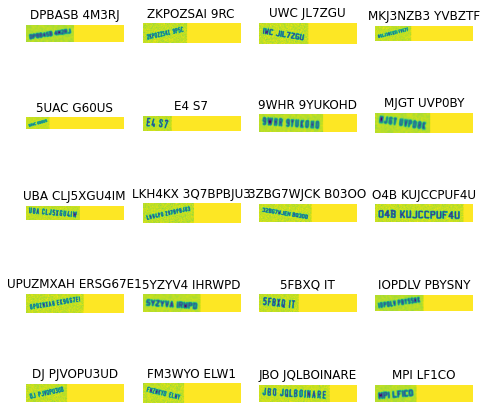

Character Accuracy: 77.46
Word Accuracy: 0.39


In [ ]:


args['imgdir'] = 'val'
args['data'] = SynthDataset(args)
resume_file = os.path.join(args['save_dir'], args['name'], 'best.ckpt')
if os.path.isfile(resume_file):
    print('Loading model %s'%resume_file)
    checkpoint = torch.load(resume_file)
    model.load_state_dict(checkpoint['state_dict'])
    args['model'] = model
    ca, wa = get_accuracy(args)
    print("Character Accuracy: %.2f\nWord Accuracy: %.2f"%(ca, wa))
else:
    print("=> no checkpoint found at '{}'".format(os.path.join(args['save_dir'], args['name'])))
    print('Exiting')



In [ ]:
!git clone https://github.com/Deepayan137/Adapting-OCR.git

Cloning into 'Adapting-OCR'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 138 (delta 60), reused 113 (delta 43), pack-reused 0
Receiving objects: 100% (138/138), 2.49 MiB | 2.36 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [ ]:
!python Adapting-OCR/main.py --name exp1 --path /content

Traininig Data Size:24562
Val Data Size:6141
checkpoint does not exist
None
Scheduling is False
Epoch: [0]/[50] Training:  29% 225/768 [00:23<00:56,  9.57it/s, loss=3.72, train_ca=0, train_wa=0]Traceback (most recent call last):
  File "Adapting-OCR/main.py", line 105, in <module>
    learner.fit(args)
  File "Adapting-OCR/main.py", line 55, in fit
    train_result = trainer.run_epoch()
  File "/content/Adapting-OCR/src/modules/trainer.py", line 124, in run_epoch
    for batch_nb, batch in enumerate(pbar):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/std.py", line 1104, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 435, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1085, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1111, in _process_data

In [ ]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 5.6MB/s 
     |████████████████████████████████| 133kB 16.3MB/s 
     |████████████████████████████████| 7.2MB 18.6MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
ERROR: botocore 1.19.54 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
